In [7]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from keras import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
import math
from keras.layers import SimpleRNN
from statistics import stdev
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [8]:
#Open the dataset 
dataset = pd.read_csv('Desktop/GOOGL.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [9]:
#Examine data
dataset.shape

(4431, 7)

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB


In [11]:
dataset.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [12]:
#Check if data missing
dataset.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [13]:
#Change type of date to datetime type 
dataset.Date=pd.to_datetime(dataset['Date'])

In [14]:
dataset.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [15]:
#Analyse date data
dataset.Date.min(),dataset.Date.max()
dataset.Date.max()-dataset.Date.min()

Timedelta('6426 days 00:00:00')

In [16]:
#Create column for date to use in graph
dataset.set_index('Date',inplace=True)
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602
...,...,...,...,...,...,...
2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100
2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600
2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800


In [17]:
#Start test for stationary data
#Strat by splitting data into chunks
np.round(dataset.shape[0]/10,0)

443.0

In [38]:
def stationaryTest1(dataset):
    split = np.round(dataset.shape[0]/10,0)
    #Statistics for each chunks to find if large deviation in 
    #mean or variance -- data is probably not stationary
    mean=[]
    std=[]

    for i in range(0,10):
        mean.append(dataset['High'].iloc[(i*443):(i*443)+443].mean())
        std.append(stdev(dataset['High'].iloc[(i*443):(i*443)+443]))
    #Chart of mean and std
    return(pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1))
def stationaryTest2(dataset):
    #Since clearly different in each chunk
    #Assume non stationary

    #Need more test
    #Augmented Dickey-Fuller test
    #H0: non stationary
    #H1: stationary

    result = adfuller(dataset['High'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return

In [39]:
stationaryTest(dataset)

,mean,std
0,140.365196,51.153975
1,253.262980,46.102784
2,220.912289,43.122744
3,277.775461,24.652126
4,338.114265,47.663683
5,537.664131,54.208791
6,710.515983,88.280105
7,1021.089795,126.361815
8,1229.109186,124.523716
9,2263.732568,524.220412


In [40]:
stationaryTest2(dataset)

ADF Statistic: 3.414008
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [15]:
#P-values > 0.05 and ADF higher then any critical point
#No reason to reject H0 so data is non stationary
#This give us info that it will take a long time to train model

ADF Statistic: 3.414008
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [96]:
#Choose data wanted to predict
new_dataset=dataset['High'].iloc[:-4]
#Choose step 15 because fit better after testing strat
step=15

#Split dataset to train 80% and test 20%
train_len = math.ceil(len(new_dataset)*0.8)

In [97]:
def SplitData(new_dataset,train_len):
    train_data = new_dataset[0:train_len]
    test_data = new_dataset[train_len-step:]
    return(train_data,test_data)
def TrainData(dataset):
    step=15
    #Train dataset
    X_train=[]
    Y_train=[]

    for i in range(step, len(train_data)):
        X_train.append(train_data[i-step:i])
        Y_train.append(train_data[i])
    X_train, Y_train= np.array(X_train), np.array(Y_train)
    #Reshaping train data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print(X_train.shape)
    return (X_train, Y_train)
def TestData(new_dataset):
    #Split test data
    test_data = new_dataset[train_len-step:]

    X_test=[]
    Y_test=[] 

    for i in range(step, len(test_data)):
        X_test.append(test_data[i-step:i])
        Y_test.append(test_data[i])
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    #Reshaping data test
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    return(X_test,Y_test)

In [98]:
train_data, test_data=SplitData(new_dataset,train_len )

In [99]:
X_train, Y_train =TrainData(dataset)

(3527, 15, 1)


In [108]:
def model(dataset):
    #Model RNN with layers
    model=Sequential()
    model.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(SimpleRNN(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dense(25))
    model.add(Dense(1))

    #Compile RNN
    opt1=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)
    return(model)

In [109]:
model=model(dataset)

In [110]:
X_test, Y_test = TestData(new_dataset)

In [111]:
prediction = model.predict(X_test)

28/28 [==============================] - 2s 16ms/step


In [131]:
def predictionChart(X_test,X_train):
    #Prediction
    RNN_train_pred = model.predict(X_train)
    RNN_valid_pred = model.predict(X_test)
    #Chart of prediction and real value
    valid = pd.DataFrame(new_dataset[train_len:])
    valid['Predictions']=RNN_valid_pred
    valid
    return(valid,RNN_train_pred,RNN_valid_pred )

def predictionGraph1(valid):
    plt.plot(valid[['High','Predictions']])
    plt.legend(['Validation','Predictions'])
    plt.show()
    return

In [132]:
valid, RNN_train_pred, RNN_valid_pred  = predictionChart(X_test,X_train)

28/28 [==============================] - 0s 12ms/step


In [133]:
valid

,High,Predictions
Date,,
2018-09-13,1187.859985,1191.987671
2018-09-14,1188.000000,1188.944336
2018-09-17,1181.819946,1189.287964
2018-09-18,1181.329956,1182.280884
2018-09-19,1176.270020,1182.688110
...,...,...
2022-03-14,2608.179932,2681.521484
2022-03-15,2597.090088,2600.343018
2022-03-16,2666.659912,2601.122803


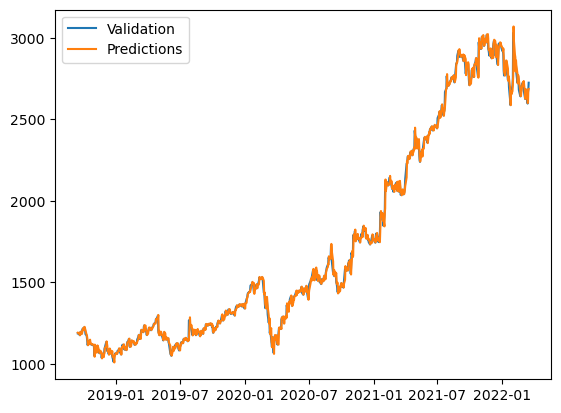

In [134]:
predictionGraph1(valid)

In [135]:
def predictionGraph2(valid):
    train = new_dataset[:train_len]
    valid = pd.DataFrame(new_dataset[train_len:])
    valid['Predictions']=RNN_valid_pred

    plt.figure(figsize=(16,8))
    plt.title('Model RNN')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD')
    plt.plot(train)
    plt.plot(valid[['High','Predictions']])
    plt.legend(['Train','Validation','Predictions'])
    plt.show()
    return

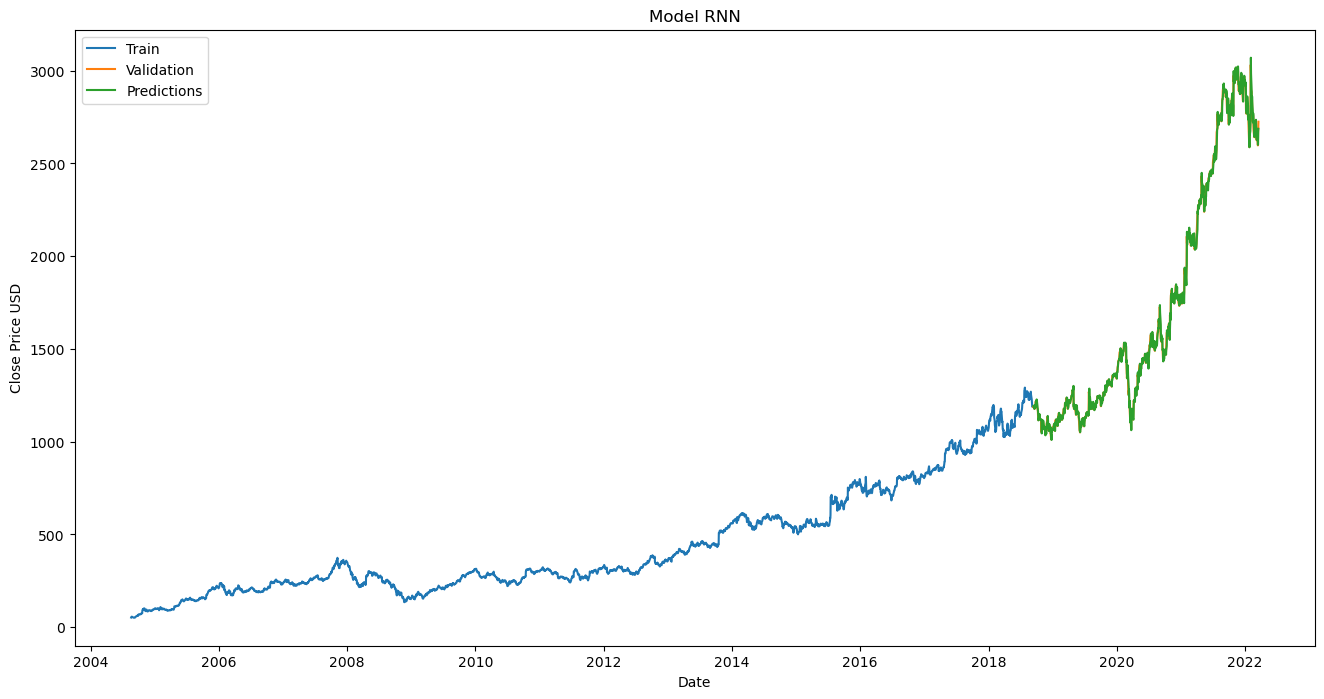

In [136]:
predictionGraph2(valid)

In [139]:
def accuracyRMSE():
    #Metric error
    print('Train RMSE:', np.sqrt(mean_squared_error(Y_train, RNN_train_pred)))
    print('Validation RMSE:', np.sqrt(mean_squared_error(Y_test, RNN_valid_pred)))
    return

In [140]:
accuracyRMSE()

Train RMSE: 6.7830321313142
Validation RMSE: 28.636121862957676


In [210]:
def futurPrediction1(num):
    #Predict futur value after 2022-03-18
    last_days=new_dataset[-num:].values
    X_test=[]
    X_test.append(last_days)
    X_test=np.array(X_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    pred_price=model.predict(X_test)
    print(pred_price)
    return(pred_price)
def futurPrediction2(num):
    last_days=new_dataset[-num:].values
    X_test=[]
    #Add price calculated
    X_test=np.append(last_days,pred_price)
    X_test=np.array(X_test)
    X_test
    X_test=np.reshape(X_test,(1,X_test.shape[0],1))
    pred_price2=model.predict(X_test)
    print(pred_price2)
    return(pred_price2)
def comparePrediction(num):
    #display the days after 2022-03-18
    print(dataset['High'].iloc[-num])
    #Difference
    print(dataset['High'].iloc[-num]-pred_price)
    #less then 10$

    #predicting 4 new value after 2022-03-18
    print(dataset.High.tail(14))
    return


In [211]:
actual_prices=[]
pred_prices = []

In [199]:
pred_price = futurPrediction1(10)


1/1 [==============================] - 0s 152ms/step
[[2731.3489]]


In [200]:
comparePrediction(4)

2741.0
[[9.651123]]
Date
2022-03-07    2634.699951
2022-03-08    2625.000000
2022-03-09    2674.709961
2022-03-10    2665.439941
2022-03-11    2675.909912
2022-03-14    2608.179932
2022-03-15    2597.090088
2022-03-16    2666.659912
2022-03-17    2681.610107
2022-03-18    2724.879883
2022-03-21    2741.000000
2022-03-22    2821.000000
2022-03-23    2791.770020
2022-03-24    2832.379883
Name: High, dtype: float64


In [201]:
pred_price2 = futurPrediction2(9)

1/1 [==============================] - 0s 245ms/step
[[2730.1348]]


In [202]:
comparePrediction(3)

2821.0
[[89.65112]]
Date
2022-03-07    2634.699951
2022-03-08    2625.000000
2022-03-09    2674.709961
2022-03-10    2665.439941
2022-03-11    2675.909912
2022-03-14    2608.179932
2022-03-15    2597.090088
2022-03-16    2666.659912
2022-03-17    2681.610107
2022-03-18    2724.879883
2022-03-21    2741.000000
2022-03-22    2821.000000
2022-03-23    2791.770020
2022-03-24    2832.379883
Name: High, dtype: float64


In [206]:
pred_price2 = futurPrediction2(8)

1/1 [==============================] - 0s 195ms/step
[[2736.1255]]


In [207]:
comparePrediction(2)

2791.77002
[[60.421143]]
Date
2022-03-07    2634.699951
2022-03-08    2625.000000
2022-03-09    2674.709961
2022-03-10    2665.439941
2022-03-11    2675.909912
2022-03-14    2608.179932
2022-03-15    2597.090088
2022-03-16    2666.659912
2022-03-17    2681.610107
2022-03-18    2724.879883
2022-03-21    2741.000000
2022-03-22    2821.000000
2022-03-23    2791.770020
2022-03-24    2832.379883
Name: High, dtype: float64


In [208]:
pred_price2 = futurPrediction2(7)

1/1 [==============================] - 0s 346ms/step
[[2726.308]]


In [209]:
comparePrediction(1)

2832.379883
[[101.031006]]
Date
2022-03-07    2634.699951
2022-03-08    2625.000000
2022-03-09    2674.709961
2022-03-10    2665.439941
2022-03-11    2675.909912
2022-03-14    2608.179932
2022-03-15    2597.090088
2022-03-16    2666.659912
2022-03-17    2681.610107
2022-03-18    2724.879883
2022-03-21    2741.000000
2022-03-22    2821.000000
2022-03-23    2791.770020
2022-03-24    2832.379883
Name: High, dtype: float64
